<a href="https://colab.research.google.com/github/cedamusk/AI-N-ML/blob/main/Mineral_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mineral Classification using CNN
## Introduction
Mineral classification is essential for geological studies and industrial applications. This project leverages a Convolutional Neural Network (CNN) to automate the process of classifying based on their charateristics, extracted from a dataset of labelled images.

## Objectives
To build a CNN model that classifies minerals accurately, achieving optimal performance using advanced deep learning techniques.

## Project workflow


1.   Data collection: Dataset obtained from kaggle, https://drive.google.com/drive/folders/1dxdZDLxnnPqp3-wWrXg56Q1s3l8LeGlC?usp=drive_link, link to dataset.
2.   Data processing ad preparation
3.   Model building
4.   Model training
5.   Analyse training results
6.   Generate predictions and report.
7.   Save the model
8.   Run the workflow





### Install dependecies

In [ ]:
!pip install google-colab tensorflow numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


### Import dependencies

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

### Mount the dataset

In [ ]:
def mount_google_drive():
  drive.mount('/content/drive')

In [ ]:
def check_directory_contents(path):
  for item in os.listdir(path):
    print(item)

In [ ]:
mount_google_drive()
dataset_path='/content/drive/MyDrive/minet'
check_directory_contents(dataset_path)

Mounted at /content/drive
biotite
pyrite
muscovite
bornite
malachite
quartz
chrysocolla


### Convolutional Neural Network architecture
The function below defines the CNN for multi-class classification tasks, such as identifying minerals from images. It starts with an input layer, followed by an initial convolutional block for basic feature extraction. The core of the network includes two residual blocks that enhance learning by combining processed features with skip connections, preventing vanishing gradients and enabling deeper learning. Each block applies two convolutional layers, batch normalization, ReLU activation and max pooling. The network concludes with global average pooling to reduce dimensionality, dense layers for classification and regularization using dropout and batch normalization. A final softmax layer outputs probabilities for the target classes. This architecture balances feature extraction, depth and regularizatin for robust performance in image classification tasks.


In [ ]:
def create_mineral_cnn(input_shape, num_classes):
  inputs=layers.Input(shape=input_shape)

  x=layers.Conv2D(64, (3,3), padding='same')(inputs)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x=layers.MaxPooling2D((2,2))(x)

  for filters in [128, 256]:
    residual=x

    x=layers.Conv2D(filters, (3,3), padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation('relu')(x)
    x=layers.Conv2D(filters, (3,3), padding='same')(x)
    x=layers.BatchNormalization()(x)

    if residual.shape[-1] !=filters:
      residual=layers.Conv2D(filters, (1,1))(residual)

    x=layers.Add()([x, residual])
    x=layers.Activation('relu')(x)
    x=layers.MaxPooling2D((2,2))(x)

  x=layers.GlobalAveragePooling2D()(x)
  x=layers.Dropout(0.5)(x)
  x=layers.Dense(512, activation='relu')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(0.5)(x)
  outputs=layers.Dense(num_classes, activation='softmax')(x)

  return models.Model(inputs, outputs)


### Data processing
The **prepare_data** function preprocesses and augments image data for training and validation in a deep learning model. It uses `ImageDataGenerator` to rescale pixel values to [0,1] and applies augmentations like rotations, shifts, flips, zooming and fill modes to the training data, while the validation data is only rescaled. The function splits the data into training (80%) and validation (20%) subsets and resizes images to a specified height and width. It generates batches of data with labels in categorical format for multi-class classification. The function returns two generators, `train_generator` and `validation_generator`, which can be used directly in model training

In [ ]:
def prepare_data(data_dir, img_height=224, img_width=224, batch_size=32):
  train_datagen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.2
  )

  test_datagen=ImageDataGenerator(rescale=1./255)

  train_generator=train_datagen.flow_from_directory(
      data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      subset='training'
  )

  validation_generator=train_datagen.flow_from_directory(
      data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, validation_generator

### Training the model
The **train_model** function trains the model using the Adam optimizer with a learning rate of 0.001, categorical cross-entropy loss for multi-class classification, and metrics including accuracy and Area Under the Curve (AUC). It incorporates three callbacks; early stopping to halt training if validation loss doesn't improve for 15 epochs, learning rate reduction to adjust the rate when progress stagnates, and model checkpointing to save the best model on validation accuracy. The model is trained on data from the provided `train_generator` and `validation_generator` for a specified number of epochs, with the training process logged in a history object that is returned for evaluation


In [ ]:
def train_model(model, train_generator, validation_generator, epochs=100):

  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy', tf.keras.metrics.AUC()]
  )

  early_stopping=tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=15,
      restore_best_weights=True
  )

  reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.2,
      patience=5,
      min_lr=1e-6
  )

  checkpoint=tf.keras.callbacks.ModelCheckpoint(
      'best_model.keras',
      monitor='val_accuracy',
      save_best_only=True,
      mode='max'
  )

  history=model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      callbacks=[early_stopping, reduce_lr, checkpoint]
  )

  return history

### Visualization of training history
The function below visualizes the training and validation performance of the model. It creates a 2 by 2 grid of plots to display accuracy, loss and AUc metrics for both training and validation data. Each plot is labelled wit titles, axes and legends for clarity, showing how the model's performance evolved over time. the function adjusts subplot spacing for a clean layout and displays the plots, helping to evaluate convergence, overfitting and overall model performance.

In [ ]:
def plot_training_history(history):
  fig, axes=plt.subplots(2,2, figsize=(15, 10))

  axes[0,0].plot(history.history['accuracy'])
  axes[0,0].plot(history.history['val_accuracy'])
  axes[0,0].set_title('Model Accuracy')
  axes[0,0].set_xlabel('Epoch')
  axes[0,0].set_ylabel("Accuracy")
  axes[0,0].legend(['Train', 'Validation'])

  axes[0,1].plot(history.history['loss'])
  axes[0,1].plot(history.history['val_loss'])
  axes[0,1].set_title('Model loss')
  axes[0,1].set_xlabel('Epoch')
  axes[0,1].set_ylabel('Loss')
  axes[0,1].legend(['Train', 'Validation'])

  axes[1,0].plot(history.history['auc'])
  axes[1,0].plot(history.history['val_auc'])
  axes[1,0].set_title('Model AUC')
  axes[1,0].set_xlabel('Epoch')
  axes[1,0].set_ylabel('AUC')
  axes[1,0].legend(['Train', 'Validation'])

  plt.tight_layout()
  plt.show()

### The Confusion Matrix
A confusion matrix is a table used to evaluate the performance of a classification model by comparing the predicted labels with the actual (true) labels. It provides a summary of prediction outcomes for a classification problem, showing the counts of correctly and incorrectly classified instances for each class.

The `plot_confusion_matrix` function generates a confusion matrix to evaluate the model's performance on the validation set. It first uses the model to predict the class labels for the validation data, then compares the predicted labels with the true labels to compute the confusion matrix. This matrix is visualized as a heatmap using seaborn, with annotations showing how the count of predictions for each class. The plot includes a title and labelled axes to help interpret the results.


In [ ]:
def plot_confusion_matrix(model, validation_generator):
  predictions=model.predict(validation_generator)
  y_pred=np.argmax(predictions, axis=1)
  y_true=validation_generator.class_indices

  cm=confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(10,8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel("True label")
  plt.xlabel('Predicted label')
  plt.show()

### Reciever Operating Characteristic
the funtion below visualizes the Receiver Operating Characteristic (ROC) curves for a multi-class classification model. It computes the True Positive Rate (TPR) and the False Positive Rate (FPR) foreach class by comparing the one-hot-encoded true labels with the predicted probabilities. Each ROC curve is plotted alongside its Area Under the Curve (AUC) score, which quantifies the model's ability to distinguish between classes. A diagonal line is included as a baseline, representing a random classifier (AUC=0.5). The function customizes the plot with axis labels, a title, and a legend, providing a comprehensive visual evaluation of the model's classification performance.

In [ ]:
def plot_roc_curves(model, validation_generator):
  predictions=model.predict(validation_generator)
  y_true=label_binarize(validation_generator.classes,
                        classes=range(len(validation_generator.class_indices)))

  plt.figure(figsize=(10,8))

  for i in range(len(validation_generator.class_indices)):
    fpr, tpr, _=roc_curve(y_true[:, i], predictions[:,i])
    roc_auc=auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class{i}(AUC={roc_auc:.2f})')

  plt.plot([0,1], [0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc='lower right')
  plt.show()



### Main
The `main()` function organizes the entire pipeline for training, validating and evaluating a CNN to clasiify mineral immages. It loads the data, builds and trains the model, visualizes its performance using metrics and plots, and generates a classification report. Finally it saves the trained model for deployment. This modular approach ensures all steps are executed sequentially within a single function.

In [ ]:
def main():
  DATA_DIR='/content/drive/MyDrive/minet'
  IMG_HEIGHT=224
  IMG_WIDTH=224
  BATCH_SIZE=32
  EPOCHS=100

  train_generator, validation_generator=prepare_data(
      DATA_DIR,
      IMG_HEIGHT,
      IMG_WIDTH,
      BATCH_SIZE
  )

  num_classes=len(train_generator.class_indices)
  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

  model=create_mineral_cnn(input_shape, num_classes)

  history=train_model(model, train_generator, validation_generator, EPOCHS)

  plot_training_history(history)
  plot_confusion_matrix(model, validation_generator)
  plot_roc_curves(model, validation_generator)

  predictions=model.predict(validation_generator)
  y_pred=np.argmax(predictions, axis=1)
  print('\nClassification Report:')
  print(classification_report(validation_generator.classes, y_pred,
                              target_names=list(train_generator.class_indices.keys())))
  model.save('mineral_classifier.keras')

### Execution
The line `if __name__ == '__main__': main()` ensures that the `main()` function is executed only when the script is run directly, not when it is imported as a module into another script. In Python, the special variable `__name__` is set to `'__main__'` when a file is executed directly. If the file is imported, `__name__` is instead set to the module's name, and the code inside this conditional block will not run. This construct allows the script to function both as a standalone program and as a reusable module without triggering unintended execution. In this case, it ensures that the entire mineral classification pipeline—data preparation, model training, evaluation, and saving—executes only when the file is explicitly run.


Found 768 images belonging to 7 classes.
Found 189 images belonging to 7 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 653s 25s/step - accuracy: 0.2669 - auc: 0.6366 - loss: 2.5452 - val_accuracy: 0.2646 - val_auc: 0.6720 - val_loss: 1.8379 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 581s 23s/step - accuracy: 0.4819 - auc: 0.8177 - loss: 1.6432 - val_accuracy: 0.3598 - val_auc: 0.7072 - val_loss: 1.7044 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 544s 23s/step - accuracy: 0.5545 - auc: 0.8613 - loss: 1.4554 - val_accuracy: 0.3651 - val_auc: 0.7161 - val_loss: 1.6926 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 546s 23s/step - accuracy: 0.6265 - auc: 0.8874 - loss: 1.2433 - val_accuracy: 0.2434 - val_auc: 0.6508 - val_loss: 1.8941 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 557s 22s/step - accuracy: 0.5996 - auc: 0.8933 - loss: 1.1831 - val_accuracy: 0.2698 - val_auc: 0.6877 - val_loss: 1.9037 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 594s 25s/step - accuracy: 0.6001 - auc: 0.8859 -

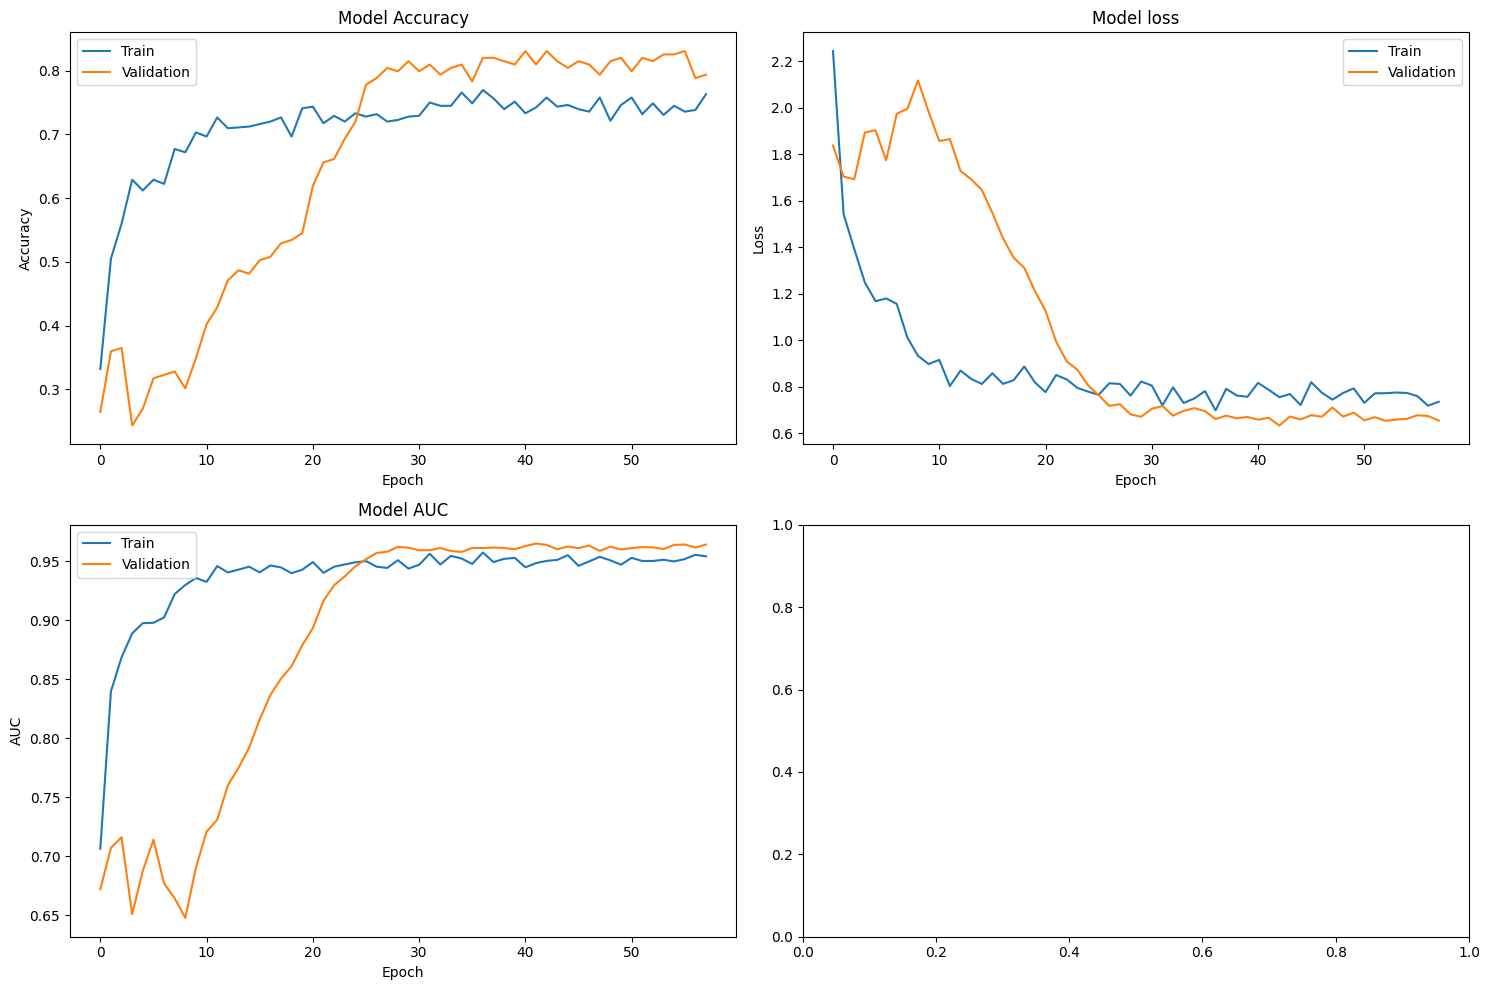

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step


ValueError: Found input variables with inconsistent numbers of samples: [7, 189]

In [ ]:
if __name__=='__main__':
  main()